# Demo

In this demo we are going to fit some of the RNNs to create artificial psychometric, and performance curves.

In [9]:
import os
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from scipy.stats import sem
import scipy
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools
import pickle as pkl
import nn_pytorch
import miscellaneous_ANN
import miscellaneous
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from numpy.random import permutation
nan=float('nan')

script_dir = os.path.dirname(os.path.abspath('demo'))

/home/ramon/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ramon/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Let's determine the parameters for the RNNs

In [10]:
# Parameters       
n_trials_train=200
n_trials_test=200
t_steps=20
xx=np.arange(t_steps)/10

batch_size=100#1000
n_hidden=10
sigma_train=1
sigma_test=1
input_noise=1
scale_ctx=1 
ctx_noise=0 

reg=1e-5
lr=0.001
n_epochs=200#1000
n_files=3

# Different coherences
coh_uq=np.linspace(-1,1,11)
coh_uq_abs=coh_uq[coh_uq>=0]

# Asymmetry in the environment. [1,1] corresponds to symmetric environment. 
wei_ctx=[4,1] 

# Strength of sparsity term in loss function
beta=0
b_exp=1

Fit the different RNNs as independent simulations

In [7]:
# Iitialize some of the vectors
perf_task=nan*np.zeros((n_files,2,len(coh_uq),t_steps))
perf_task_abs=nan*np.zeros((n_files,2,len(coh_uq_abs),t_steps))
psycho=nan*np.zeros((n_files,len(coh_uq),t_steps,3))

# For loop on different independent simulations. 
for hh in range(n_files):
    print (hh)
    # Def variables
    all_train=miscellaneous_ANN.create_input(n_trials_train,t_steps,coh_uq,input_noise,scale_ctx=scale_ctx,ctx_noise=ctx_noise)
    all_test=miscellaneous_ANN.create_input(n_trials_test,t_steps,coh_uq,input_noise,scale_ctx=scale_ctx,ctx_noise=ctx_noise)
    context=all_test['context']
    ctx_uq=np.unique(context)
    stimulus=all_test['target_vec'].detach().numpy()
    coherence=all_test['coherence']

    # Train RNN
    rec=nn_pytorch.nn_recurrent_sparse(reg=reg,lr=lr,output_size=2,hidden_dim=n_hidden)   
    rec.fit(input_seq=all_train['input_rec'],target_seq=all_train['target_vec'],context=all_train['context'],batch_size=batch_size,n_epochs=n_epochs,sigma_noise=sigma_train,wei_ctx=wei_ctx,beta=beta,b_exp=b_exp)

    # Indices trials
    index0=np.where(all_test['target_vec']==0)[0]
    index1=np.where(all_test['target_vec']==1)[0]
    # Hidden units' activity
    ut_train=rec.model(all_train['input_rec'],sigma_noise=sigma_train)[2].detach().numpy()
    ut_test=rec.model(all_test['input_rec'],sigma_noise=sigma_test)[2].detach().numpy()
    # Decision units activity
    zt_train=rec.model(all_train['input_rec'],sigma_noise=sigma_train)[3].detach().numpy()
    zt_test=rec.model(all_test['input_rec'],sigma_noise=sigma_test)[3].detach().numpy()
    # Network Choice
    dec_train=np.argmax(zt_train,axis=2)
    dec_test=np.argmax(zt_test,axis=2)
        
    # Plot performance
    corr_train=all_train['target_vec'].detach().numpy()
    corr_test=all_test['target_vec'].detach().numpy()
    for j in range(t_steps):
        for jj in range(len(coh_uq)):
            ind_coh_tr=np.where(all_train['coherence']==coh_uq[jj])[0]
            ind_coh_te=np.where(all_test['coherence']==coh_uq[jj])[0]
            perf_task[hh,0,jj,j]=np.mean(dec_train[ind_coh_tr][:,j]==corr_train[ind_coh_tr])
            perf_task[hh,1,jj,j]=np.mean(dec_test[ind_coh_te][:,j]==corr_test[ind_coh_te])

    # Plot performance Absolute coherence
    dec_train=np.argmax(zt_train,axis=2)
    dec_test=np.argmax(zt_test,axis=2)
    corr_train=all_train['target_vec'].detach().numpy()
    corr_test=all_test['target_vec'].detach().numpy()
    for j in range(t_steps):
        for jj in range(len(coh_uq_abs)):
            ind_coh_tr=np.where(abs(all_train['coherence'])==coh_uq_abs[jj])[0]
            ind_coh_te=np.where(abs(all_test['coherence'])==coh_uq_abs[jj])[0]
            perf_task_abs[hh,0,jj,j]=np.mean(dec_train[ind_coh_tr][:,j]==corr_train[ind_coh_tr])
            perf_task_abs[hh,1,jj,j]=np.mean(dec_test[ind_coh_te][:,j]==corr_test[ind_coh_te])

    # Psychometric
    for j in range(t_steps):
        for i in range(len(coh_uq)):
            psycho[hh,i,j,0]=np.mean(dec_test[:,j][(coherence==coh_uq[i])])
            psycho[hh,i,j,1]=np.mean(dec_test[:,j][(coherence==coh_uq[i])&(context==ctx_uq[0])])
            psycho[hh,i,j,2]=np.mean(dec_test[:,j][(coherence==coh_uq[i])&(context==ctx_uq[1])])


0
0 3.0194697 0.63138944
199 1.4482907 0.85913336
1
0 2.9308114 0.6429155
199 1.7252384 0.81266063
2
0 3.1437469 0.6360537
199 1.4656628 0.8323081


Plot probability of correct response as a function of time

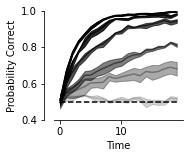

In [11]:
# Plot performance vs time for different coherences
perf_abs_m=np.mean(perf_task_abs,axis=0)
perf_abs_sem=sem(perf_task_abs,axis=0)

fig=plt.figure(figsize=(2.3,2))
ax=fig.add_subplot(111)
miscellaneous.adjust_spines(ax,['left','bottom'])
for i in range(len(coh_uq_abs)):
    ax.plot(np.arange(t_steps),perf_abs_m[1,i],color='black',alpha=(i+1)/len(coh_uq_abs))
    ax.fill_between(np.arange(t_steps),perf_abs_m[1,i]-perf_abs_sem[1,i],perf_abs_m[1,i]+perf_abs_sem[1,i],color='black',alpha=(i+1)/len(coh_uq_abs))
ax.plot(np.arange(t_steps),0.5*np.ones(t_steps),color='black',linestyle='--')
ax.set_ylim([0.4,1])
ax.set_ylabel('Probability Correct')
ax.set_xlabel('Time')

fig.savefig(script_dir+'/plots_demo/performance_vs_time.png',dpi=500,bbox_inches='tight')


Plot psychometric curves for each time step

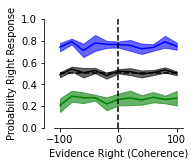

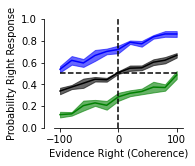

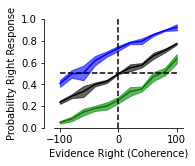

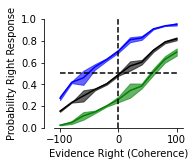

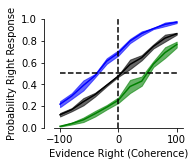

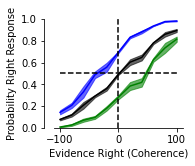

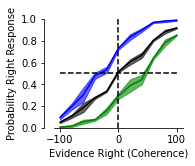

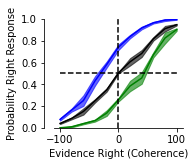

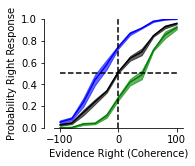

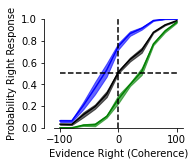

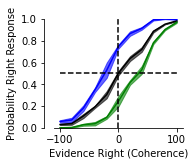

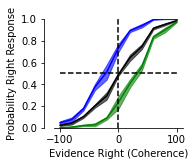

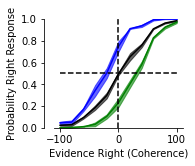

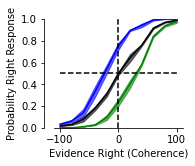

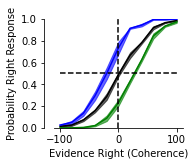

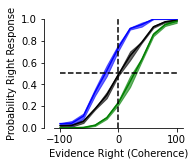

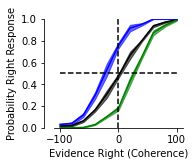

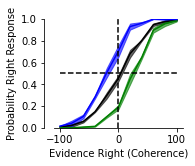

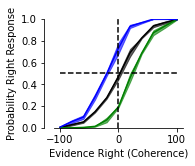

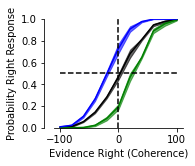

In [12]:
psycho_m=np.mean(psycho,axis=0)
psycho_sem=sem(psycho,axis=0)

for t_plot in range(t_steps):
    # Figure psychometric
    fig=plt.figure(figsize=(2.3,2))
    ax=fig.add_subplot(111)
    miscellaneous.adjust_spines(ax,['left','bottom'])
    #print (psycho_m)
    ax.plot(coh_uq*100,psycho_m[:,t_plot,0],color='black')
    ax.fill_between(coh_uq*100,psycho_m[:,t_plot,0]-psycho_sem[:,t_plot,0],psycho_m[:,t_plot,0]+psycho_sem[:,t_plot,0],color='black',alpha=0.6)
    ax.plot(coh_uq*100,psycho_m[:,t_plot,1],color='green')
    ax.fill_between(coh_uq*100,psycho_m[:,t_plot,1]-psycho_sem[:,t_plot,1],psycho_m[:,t_plot,1]+psycho_sem[:,t_plot,1],color='green',alpha=0.6)
    ax.plot(coh_uq*100,psycho_m[:,t_plot,2],color='blue')
    ax.fill_between(coh_uq*100,psycho_m[:,t_plot,2]-psycho_sem[:,t_plot,2],psycho_m[:,t_plot,2]+psycho_sem[:,t_plot,2],color='blue',alpha=0.6)
    ax.plot(coh_uq*100,0.5*np.ones(len(coh_uq)),color='black',linestyle='--')
    ax.axvline(0,color='black',linestyle='--')
    ax.set_ylim([0,1])
    ax.set_ylabel('Probability Right Response')
    ax.set_xlabel('Evidence Right (Coherence)')
    fig.savefig(script_dir+'/plots_demo/psychometric_vs_time_t%i.png'%(t_plot),dpi=500,bbox_inches='tight')
    #fig.savefig('/home/ramon/Dropbox/Proyectos_Postdoc/Esteki_Kiani/plots/figure_rnn_psychometric_t%i_rr%i%i_rnn_stefano.pdf'%(t_plot,wei_ctx[0],wei_ctx[1]),dpi=500,bbox_inches='tight')

 